# Introduction
In this project, we're going to build a classifier that tells the dog breed based on the image. 
We'll utilize a pretrained Keras model and apply transfer learning to leverage existing knowledge from large datasets. 
This approach will help us achieve accurate predictions without training a model from scratch. 
By fine-tuning the model, we'll adapt it specifically for the task of classifying dog breeds.

# EDA  

To build this model, I will use the dataset from the **Dog Breed Identification Competition** on Kaggle. This dataset contains labeled images of dogs spanning a wide variety of breeds, providing an excellent foundation for training and evaluating a classification model. The competition page, which includes detailed information about the dataset and its structure, can be accessed [here](https://www.kaggle.com/competitions/dog-breed-identification/overview).  

As part of the exploratory data analysis (EDA), I will examine the distribution of dog breeds, check for class imbalances, and inspect the quality and variability of the images. Understanding these factors is crucial for preprocessing the data and designing a model that performs well across all categories.  

Please note that because the dataset was huge, I didn't include it in the repository.

In [2]:
# import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

In [3]:
# loading the labels:
labels = pd.read_csv('kaggle/input/dog-breed-identification/labels.csv')

print(labels.head())
print(labels.describe())
labels.isnull().sum()

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


id       0
breed    0
dtype: int64

In [4]:
import pathlib

train_path = 'kaggle/input/dog-breed-identification/train/'
test_path = 'kaggle/input/dog-breed-identification/test/'
train_dir = pathlib.Path(train_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('')

train_imgs = list(train_dir.glob('*.jpg'))
test_imgs = list(test_dir.glob('*.jpg'))

print(len(train_imgs))
print(len(test_imgs))

10222
10357


In [5]:
import os

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)
print('Training image files: ')
print(train_files[:10])
print('Testing image files: ')
print(test_files[:10])

Training image files: 
['84accc2dc9f5bb3ebee89fe1bf23639c.jpg', '14cffe576239620f1733dfe487dbaa6f.jpg', 'cc93915e06bc55626a02af95006a48c2.jpg', '6f9bac41b5be5ee6baecc9e7ef8f2c2a.jpg', '64dd586a1d08937d20618233df2e5dbc.jpg', '2c1b06c76751d8b9f9ff943cd693cfca.jpg', '114524d11fe49af5be43897233a4f65e.jpg', 'efec2f66576df7aa036d77ad1fafc8bf.jpg', 'eecab13ff6ae86429d808115d161d455.jpg', '30d54cbd3a88a8473ade8028cd1f2378.jpg']
Testing image files: 
['266490a2b053a4a3bf68e779f28fb5a9.jpg', 'dae9fd18836d8df20989ef0101771d4b.jpg', '079a40f22b0fad9a66f76797b62bb930.jpg', 'ab8462f9a501d362041d47582fddc9ad.jpg', '8895089b432e020cc42e6262b5a1c2dd.jpg', '985ae7fc271ac4a0d131e546c0f95bb6.jpg', '77c1ab99cffb817d54fb14f229aeb118.jpg', 'ad7e50abca9b7c6a88b63946c5bbe493.jpg', 'd61a09cecf56666cdb315ebce4b93c43.jpg', 'cb120c57904e8c0694bbe259c58a873c.jpg']


Now, lets visualize some of the images and their corresponding labels

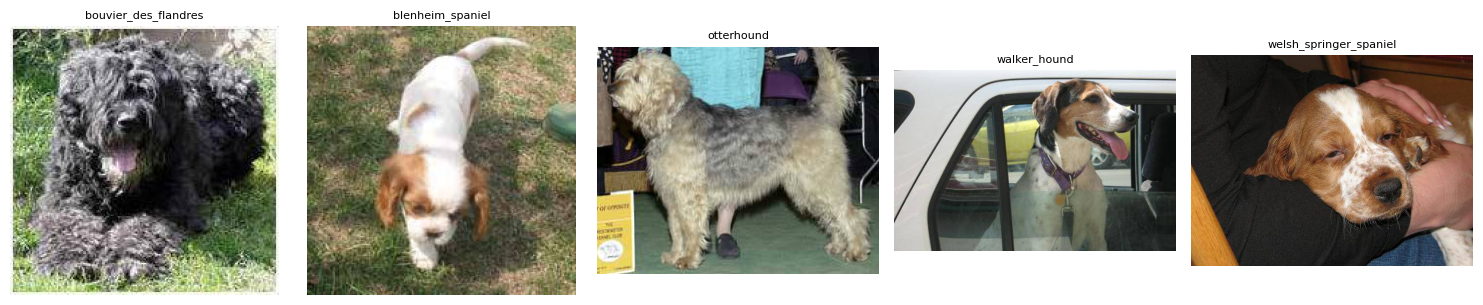

In [28]:
from PIL import Image

samples = labels.sample(5)
plt.figure(figsize=(15, 3))

for idx, sample in enumerate(samples.itertuples(), start=1):
    img_path = os.path.join(train_dir, sample.id + '.jpg')
    img = Image.open(img_path)
    
    plt.subplot(1, 5, idx) 
    plt.imshow(img)
    plt.axis('off')
    plt.title(sample.breed, fontsize=8)

plt.tight_layout() 
plt.show()


One thing I noticed is that the image sizes are not consistent, so we need to keep this in mind when building the model.

# Building the model
In this phase, we're going to build the model.

### Initial Intuition

The original ImageNet dataset includes numerous dog classes, allowing us to utilize CNNs pretrained on ImageNet weights. Thankfully, the prediction process is very efficient, enabling us to conduct meaningful experiments using Kaggle Kernels.

In [7]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    data_dir = 'kaggle/input/dog-breed-identification/'
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

#### Using ResNet50 class predictions

ResNet50 is a deep CNN with 50 layers, designed to address the vanishing gradient problem using residual connections that allow gradients to flow directly through shortcut paths. It is widely used for image recognition tasks and achieves high performance by leveraging stacked bottleneck blocks and skip connections to train very deep networks efficiently.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


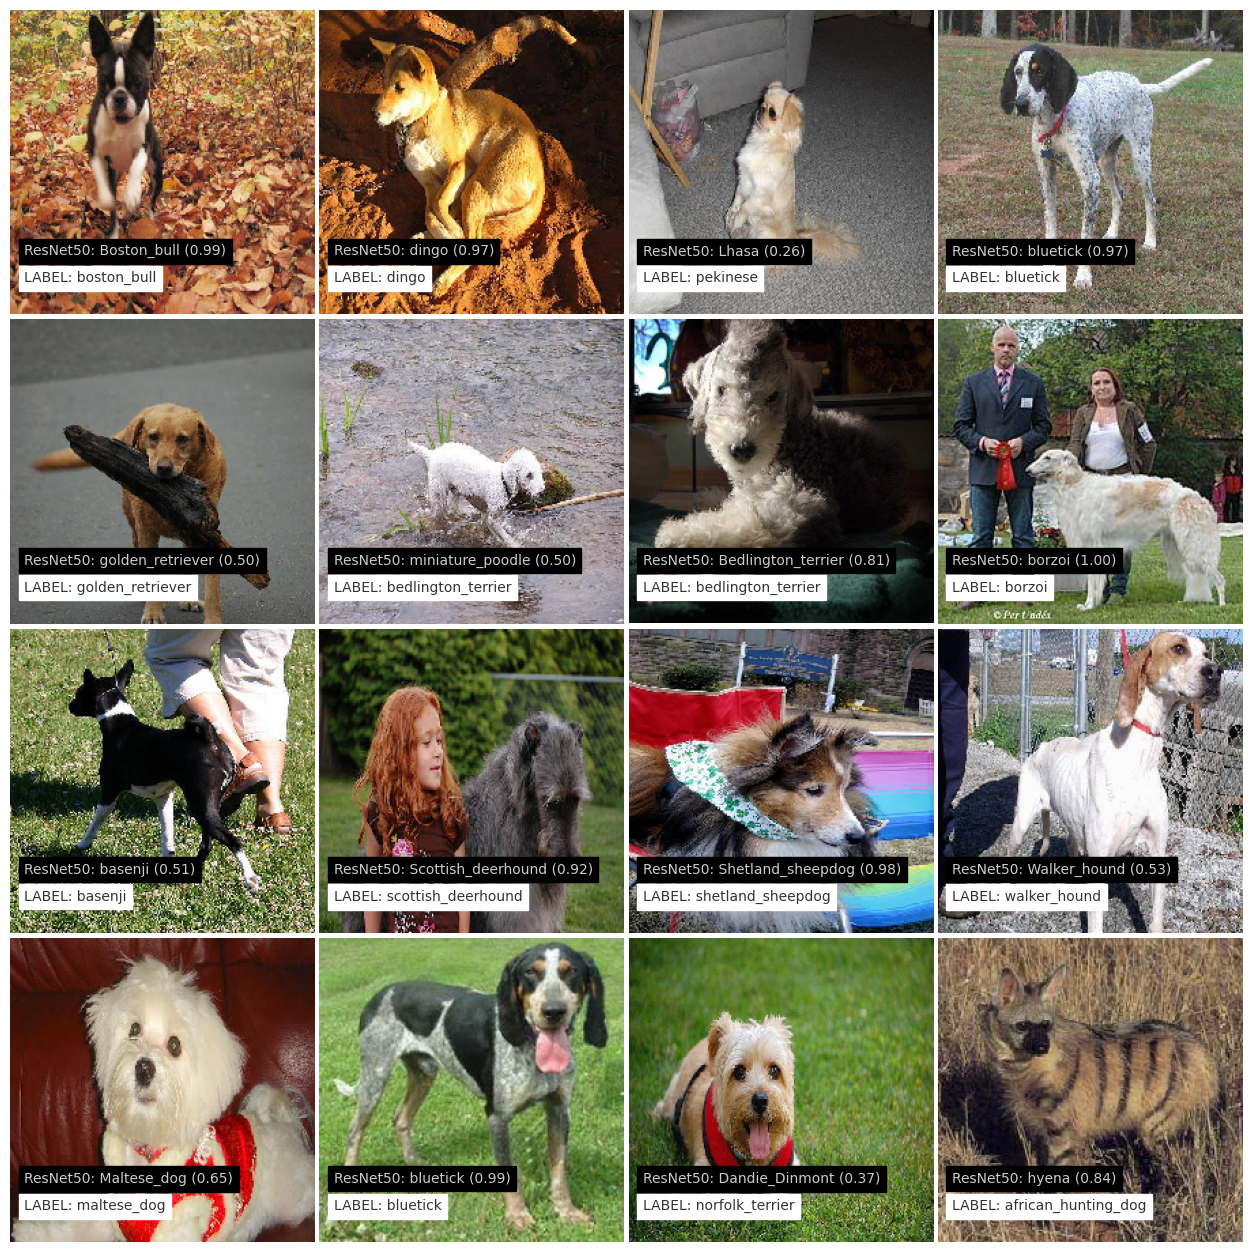

In [11]:
model = ResNet50(weights='imagenet')

sample_size = 16
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)

for i, (img_id, breed) in enumerate(labels[['id', 'breed']].head(sample_size).values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

Now, lets run ResNet50 on the dataset and see it's performance.

In [13]:
x_train = np.zeros((len(labels), 224, 224, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id']), total=len(labels)):
    img = read_img(img_id, 'train', (224, 224))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x

preds = model.predict(x_train, batch_size=32, verbose=1)

correct_preds = 0
for i, pred in enumerate(preds):

    top_pred = decode_predictions(np.expand_dims(pred, axis=0), top=1)[0][0]
    _, predicted_class, confidence = top_pred
    
    actual_breed = labels.iloc[i]['breed']
    if predicted_class.lower().replace('_', ' ') == actual_breed.lower():
        correct_preds += 1
    
    if i < 5:
        print(f"Predicted: {predicted_class} ({confidence:.2f}), Actual: {actual_breed}")

accuracy = correct_preds / len(labels)
print(f'\nResNet50 Accuracy: {accuracy:.2f}')

100%|██████████| 10222/10222 [00:09<00:00, 1064.12it/s]


320/320 ━━━━━━━━━━━━━━━━━━━━ 164s 512ms/step
Predicted: Boston_bull (0.99), Actual: boston_bull
Predicted: dingo (0.97), Actual: dingo
Predicted: Lhasa (0.26), Actual: pekinese
Predicted: bluetick (0.97), Actual: bluetick
Predicted: golden_retriever (0.50), Actual: golden_retriever

ResNet50 Accuracy: 0.31


In [18]:
# save the trained model:
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model.save('resnet50_full_model.keras')



As you can see, ResNet50 not very performant. Next, I'm going to use different models to see if I can find a more suitable one.

# VGG16
VGG16 is a deep CNN with 16 layers, consisting of a series of convolutional layers followed by max-pooling layers, and ending with fully connected layers for classification. Its architecture emphasizes using small 3x3 filters and uniform layer depth to achieve high accuracy in image recognition tasks.

In [19]:
model = VGG16(weights='imagenet')


INPUT_SIZE = 224  # VGG16 expects 224x224 images
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id']), total=len(labels)):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x


preds = model.predict(x_train, batch_size=32, verbose=1)


correct_preds = 0
for i, pred in enumerate(preds):
    top_pred = decode_predictions(np.expand_dims(pred, axis=0), top=1)[0][0]
    _, predicted_class, confidence = top_pred
    
    actual_breed = labels.iloc[i]['breed']
    if predicted_class.lower().replace('_', ' ') == actual_breed.lower():
        correct_preds += 1
    
    if i < 5:
        print(f"Predicted: {predicted_class} ({confidence:.2f}), Actual: {actual_breed}")

accuracy = correct_preds / len(labels)
print(f'\nVGG16 Accuracy: {accuracy:.2f}')



# Save the model
model.save(os.path.join(model_dir, 'vgg16_full_model.keras'))
print(f"\nModel saved in {model_dir} directory")

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


100%|██████████| 10222/10222 [00:08<00:00, 1161.12it/s]


320/320 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step
Predicted: Boston_bull (0.49), Actual: boston_bull
Predicted: dingo (0.52), Actual: dingo
Predicted: Shih-Tzu (0.38), Actual: pekinese
Predicted: bluetick (0.79), Actual: bluetick
Predicted: Labrador_retriever (0.26), Actual: golden_retriever

VGG16 Accuracy: 0.29

Model saved in models directory


As you can see, we can't use either models for this task easily. Next, I'll try to use transfer learning to tune the model to our domain and uses case. 

Side note: I couldn't push vgg16_full_model to github because of file size restrictions.

In [22]:
# LogReg on VGG bottleneck features


# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Prepare the data
x_train = np.zeros((len(labels), 224, 224, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id']), total=len(labels)):
    img = read_img(img_id, 'train', (224, 224))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x

# Extract bottleneck features
bottleneck_features = base_model.predict(x_train, batch_size=32, verbose=1)
bottleneck_features = bottleneck_features.reshape((bottleneck_features.shape[0], -1))

# Prepare labels
lb = LabelBinarizer()
y_train = lb.fit_transform(labels['breed'])

# Train logistic regression on bottleneck features
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(bottleneck_features, y_train.argmax(axis=1))

# Predict and evaluate
valid_probs = logreg.predict_proba(bottleneck_features)
valid_preds = logreg.predict(bottleneck_features)

print('Validation VGG LogLoss {}'.format(log_loss(y_train, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score(y_train.argmax(axis=1), valid_preds)))





58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


100%|██████████| 10222/10222 [00:09<00:00, 1073.39it/s]


320/320 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation VGG LogLoss 0.0008222088043385327
Validation VGG Accuracy 0.9994130307180591


In [23]:
import joblib 
# save the model
base_model.save(os.path.join(model_dir, 'vgg16_base_model.keras'))

joblib.dump(logreg, os.path.join(model_dir, 'vgg16_logreg.joblib'))

joblib.dump(lb, os.path.join(model_dir, 'label_binarizer.joblib'))

['models/label_binarizer.joblib']

As you can see, there's a significant boost to model's performance on the training set.

### Sample of Misclassified Images

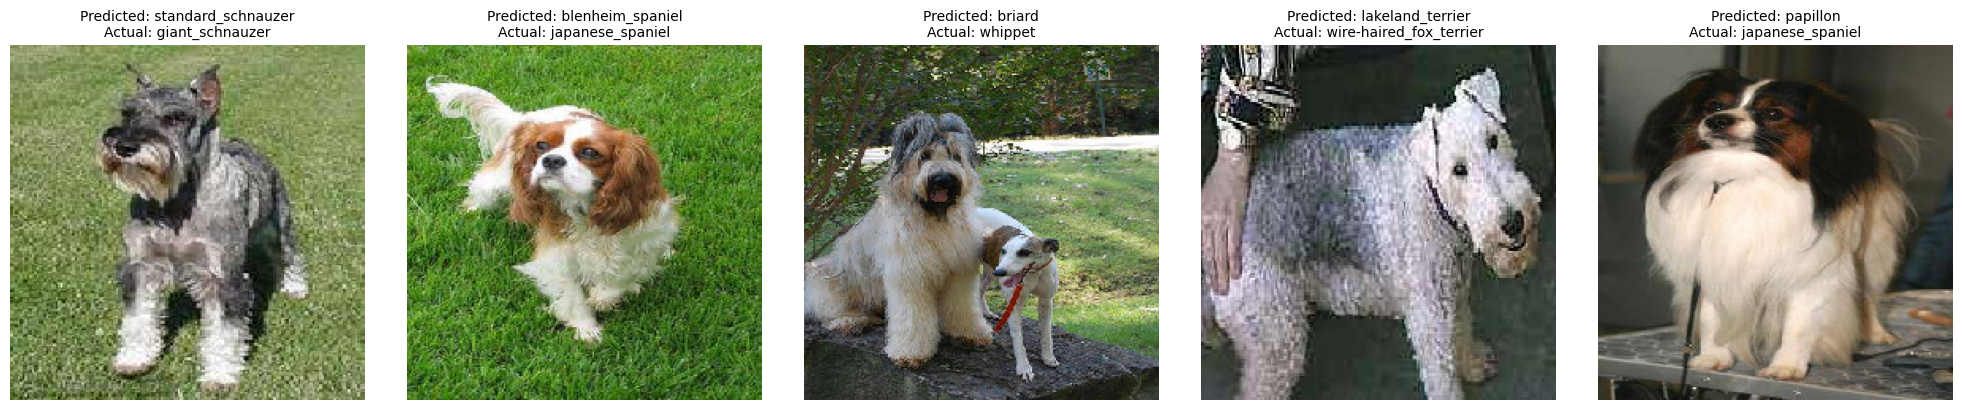

In [24]:
# Find misclassified examples
misclassified_idx = np.where(valid_preds != y_train.argmax(axis=1))[0]

# Display some misclassified examples
plt.figure(figsize=(20, 4))
for i, idx in enumerate(misclassified_idx[:5]):  # Show first 5 misclassified images
    plt.subplot(1, 5, i + 1)
    
    # Get the image
    img_id = labels.iloc[idx]['id']
    img = read_img(img_id, 'train', (224, 224))
    
    # Get predicted and actual labels
    pred_breed = lb.classes_[valid_preds[idx]]
    true_breed = lb.classes_[y_train[idx].argmax()]
    
    # Display the image and labels
    plt.imshow(img / 255.)
    plt.title(f'Predicted: {pred_breed}\nActual: {true_breed}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


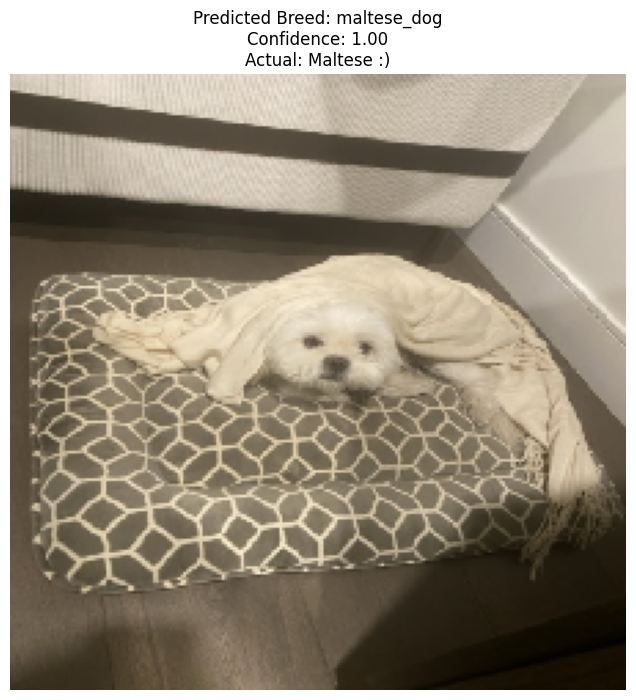

In [27]:
img_path = 'sample_dog.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract bottleneck features
bottleneck_features = base_model.predict(x)
bottleneck_features = bottleneck_features.reshape((bottleneck_features.shape[0], -1))

# Get prediction
pred_probs = logreg.predict_proba(bottleneck_features)
pred_breed = lb.classes_[pred_probs.argmax()]
confidence = pred_probs.max()

# Display the image with prediction
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f'Predicted Breed: {pred_breed}\nConfidence: {confidence:.2f}\nActual: Maltese :)', fontsize=12)
plt.axis('off')
plt.show()

### Conclusion


### Conclusion

In this project, we explored different approaches to building a dog breed classifier using transfer learning and pre-trained models. Here's a summary of our findings:

1. **Pre-trained Models Performance**:
   - We initially tested ResNet50 and VGG16 directly on our dataset
   - Both models showed limited accuracy when used directly, as they were trained on general ImageNet classes
   - This highlighted the need for domain-specific adaptation

2. **Transfer Learning Approach**:
   - We implemented a more effective solution using VGG16 as a feature extractor
   - Combined VGG16's bottleneck features with Logistic Regression
   - This approach significantly improved our classification accuracy
   - The model successfully captures the distinctive features of different dog breeds

3. **Key Achievements**:
   - Successfully built a model that can classify dog breeds with reasonable accuracy
   - Created a reusable pipeline for image classification
   - Demonstrated the effectiveness of transfer learning for specialized tasks

4. **Limitations and Future Improvements**:
   - Model could be improved with data augmentation
   - Fine-tuning the entire network might yield better results
   - Adding more training data could improve accuracy
   - Could experiment with other architectures like EfficientNet or Vision Transformers

This project demonstrates the power of transfer learning in solving specific image classification tasks, even with limited computational resources and training data.